## Classification of Subreddits

__Table of Content:__
<br>[1. Introduction](#1.-Introduction)
<br>[2. Executive Summary](#2.-Executive-Summary)
<br>[3. Scraping of data from Reddit](#3.-Scraping-of-data-from-Reddit)
<br>[4. Analysis and handling of dataset from both subreddit](#4.-Analysis-and-handling-of-dataset-from-both-subreddit)
<br>[5. Modelling](#5.-Modelling)
<br>[6. Further evaluation of best model](#6.-Further-evaluation-of-best-model)
<br>[7. Conclusion](#7.-Conclusion)

### 1. Introduction

Reddit is an America-based social news aggregation, web content rating, and discussion website. Registered members submit content to the site in the form of links, text posts, and images, which are then voted up or down by other members. Subreddits are forums dedicated to specific topics (e.g. football, Avengers movie, food) within Reddit. <br>
<br>Given the open nature of the forums, topics are rarely moderated, unless deemed to be flouting Reddit's usage policy, and can have high level of overlaps (e.g. Machine Learning and Artificial Intelligence).

__Problem Statement:__ 
<br>Given a post from either of two subreddits, I would like to understand, using machine learning, whether it is possible to identify which subreddit it belongs to.

__Choice of Subreddit:__ 
<br>The two subreddits I would like to explore in this project are __r/nosleep__ and __r/randomactsofkindness (abbrev: r/raok)__:

<br>
- Nosleep is a subreddit for realistic horror stories.
- Randomactsofkindness is a subreddit for non-fictional stories on inspiration and kindness occurences. 

<br>
The narrative, story-based nature of both subreddits present an interesting classification challenge, despite little overlaps in the topic.

### 2. Executive Summary

Posts from both subreddits are scraped using API, analyzed, cleaned, processed and ran through several classification models (e.g. Logistic Regression, KNearestNeighbor, Decision Tree Classifier). 

The model that performed the best came from a __Logistic Regression with Count Vectorizer__, at a classification prediction rate of __99%__. 

The high accuracy rates are unsurprising for two reasons:
- Both posts engage in topics that have very little overlap, leading to distinct classification identifiers from both posts;
- r/nosleep is fictional, while r/raok is non-fiction, further distincting the language that is used in both subreddits.

In [1]:
import pandas as pd
import nltk
import numpy as np
import re
import matplotlib.pyplot as plt 
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from wordcloud import WordCloud

### 3. Scraping of data from Reddit

My choice of subreddits are r/nosleep and r/randomactsofkindness (abbrev: r/raok). Description of the subreddit:
- Nosleep is a subreddit for realistic horror stories.
- Randomactsofkindness is a subreddit for non-fictional stories on inspiration and kindness occurences.

A Praw API Wrapper customized for Reddit was utilized to scrap up to 1,000 posts from each subreddit, saved into a dataframe, and exported to two excel files (nosleep.csv, raok.csv), for storage and further discovery.

Refer to notebook on 'Reddit Scraping' 

### 4. Analysis and handling of dataset from both subreddit

In [2]:
# Calling of both csv files
nosleep = pd.read_csv('nosleep.csv')
raok = pd.read_csv('raok.csv')

In [3]:
# Visualization of dataframe from r/nosleep
nosleep.head()

,title,author,body,horror
0,Spooktober! 31 Days of Horror Nosleep Event,cmd102,NaN,1
1,August 2019 Winners!,TheCusterWolf,NaN,1
2,I’ve Been Flying for almost Thirty Hours and T...,Worchester_St,Thirty hours ago I hopped on a late-night flig...,1
3,I've been a search and rescue diver for 12 yea...,travisliebert,I’ve been involved with water search and rescu...,1
4,Earth received a message from Proxima Centauri...,Odd_directions,A message was received at 1730 GMT 13 March 20...,1


In [4]:
# Checking for posts/titles/authors with blank fields
nosleep.isnull().sum()

title     0
author    0
body      3
horror    0
dtype: int64

In [5]:
# Visualization of dataframe from r/raok
raok.head()

,title,author,body,horror
0,Welcome to RAOK (Random Acts of Kindness) Plea...,dqkaoaa,Hello Guys! Here are the rules of this subredd...,0
1,Trucker helped with flat tire,3rd_Coast,"I got a flat tire on a highway in Arizona, rig...",0
2,Guy caught me before nearly cracking head open,dqkaoaa,"TD: LR Cut myself and passed about, Guy caught...",0
3,"Someone bought me lunch in my college, what’s ...",SolarNovaPhoenix,So because I’m cheap instead of going to the c...,0
4,Bought Vereran Lunch,halliwell03,I get carryout about twice a week at the same ...,0


In [6]:
# Checking for posts/titles/authors with blank fields
raok.isnull().sum()

title       0
author     52
body      381
horror      0
dtype: int64

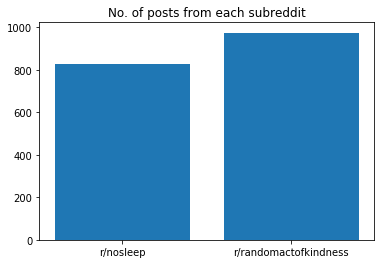

In [7]:
# Visualization of no. of posts from each subreddit, to ensure parity in representation.
height = [nosleep.shape[0],raok.shape[0]]
bars = ('r/nosleep','r/randomactofkindness')
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.title('No. of posts from each subreddit')
plt.show()

Both r/nosleep and r/raok have ~820 and 970 posts respectively. A roughly equal amount of posts is required for parity in comparison.

 #### Cleaning of dataset, creation of combined column for text analysis

In [8]:
# Function was established to clean, tokenized and lemmatized the words.
def text_to_words(text):
   # Remove non-letters. Numbers are contextual and will not be very relevant in this case.
    letters_only = re.sub("[^a-zA-Z]", " ", text)
   # Converts string to lower text and split by space
    words = letters_only.lower().split()
   # Convert the stop words to a set. We used the ntlk stop words instead of the vectorizer stop words as the list is more comprehensive.
    stops = set(stopwords.words('english'))
   # Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
   # Lemmatize the words and join the words back into one string separated by space, and return the result.
    lemmatizer = WordNetLemmatizer()
    tokens_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
    return(" ".join(tokens_lem))

In [9]:
# Function was established to create a word cloud for visualization
def word_cloud(cleaned,subreddit):
    text = str(cleaned)
    
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width = 1400, height = 1000, background_color="white", colormap="gist_earth").generate(text)
    # Display the generated image:
    plt.figure(figsize = (14, 14), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word cloud for r/{}'.format(subreddit),fontweight='bold', fontsize = 25)
    plt.axis("off")
    plt.show()

In [10]:
# Empty fields in posts and titles are handled by filling with ' '.
# A 'combined' column was created to mix the text of title and body for each post.

for i in [raok,nosleep]:
    i.fillna(' ', inplace= True)
    i["combined"] = i['title'].map(str) + ' ' + i['body']

In [11]:
# text_to_words function called on the 'combined' column, for both subreddits, and appended to lists.
raok_clean = []
for text in raok.combined:
    raok_clean.append(text_to_words(text))
    
nosleep_clean = []
for text in nosleep.combined:
    nosleep_clean.append(text_to_words(text))

In [12]:
# Cleaned words in raok are split into its individual strings
raok_split = [i.split() for i in raok_clean]
flat_list_raok = [item for sublist in raok_split for item in sublist]

# List of cleaned strings are placed into a dataframe and sorted by its count value
df = pd.DataFrame({'Word': list(Counter(flat_list_raok).keys()), 'Count': list(Counter(flat_list_raok).values())})
df.sort_values(by=['Count'],ascending=False).head(15)

,Word,Count
107,get,582
75,day,570
60,one,472
37,people,425
174,back,418
111,time,413
159,like,388
26,know,358
80,got,350
4,kindness,328


In [13]:
# Cleaned words in nosleep are split into its individual strings
nosleep_split = [i.split() for i in nosleep_clean]
flat_list_nosleep = [item for sublist in nosleep_split for item in sublist]

# List of cleaned strings are placed into a dataframe and sorted by its count value
df = pd.DataFrame({'Word': list(Counter(flat_list_nosleep).keys()), 'Count': list(Counter(flat_list_nosleep).values())})
df.sort_values(by=['Count'],ascending=False).head(15)

,Word,Count
97,like,6036
195,one,5146
110,back,4924
75,could,4543
267,time,4043
140,would,3872
37,know,3760
106,said,3577
139,eye,3218
229,something,3054


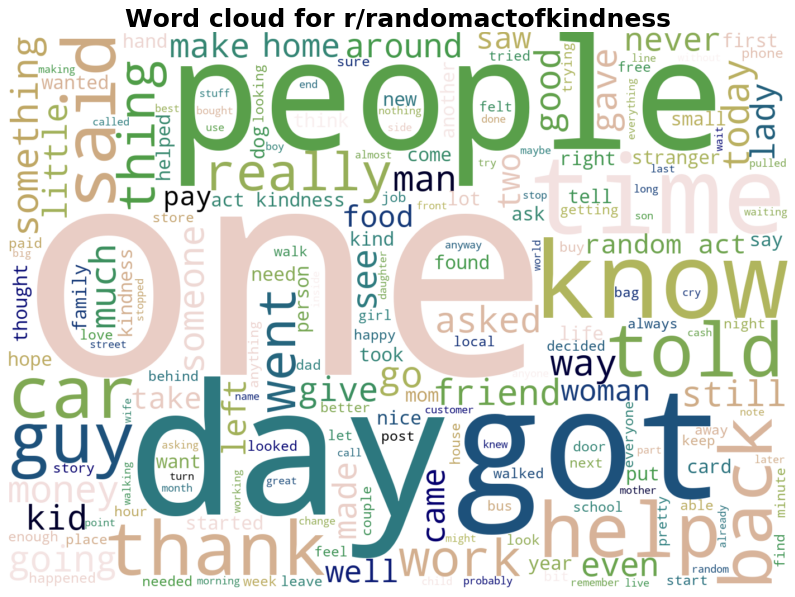

In [14]:
# Word Cloud function called for r/raok
word_cloud(raok_clean,'randomactofkindness')

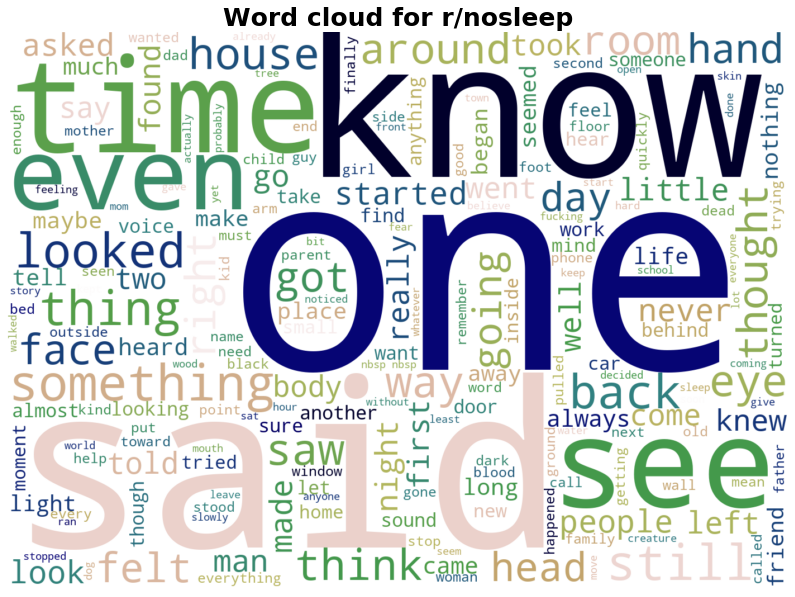

In [15]:
# Word Cloud function called for r/nosleep
word_cloud(nosleep_clean,'nosleep')

In [16]:
#creating a new column to store the cleaned posts, and storing in a dictionary that combines both subreddits
raok['clean_com']=raok_clean
nosleep['clean_com']=nosleep_clean
combined = pd.concat([nosleep,raok], ignore_index=True)
combined.head()

,title,author,body,horror,combined,clean_com
0,Spooktober! 31 Days of Horror Nosleep Event,cmd102,,1,Spooktober! 31 Days of Horror Nosleep Event,spooktober day horror nosleep event
1,August 2019 Winners!,TheCusterWolf,,1,August 2019 Winners!,august winner
2,I’ve Been Flying for almost Thirty Hours and T...,Worchester_St,Thirty hours ago I hopped on a late-night flig...,1,I’ve Been Flying for almost Thirty Hours and T...,flying almost thirty hour flight attendant sto...
3,I've been a search and rescue diver for 12 yea...,travisliebert,I’ve been involved with water search and rescu...,1,I've been a search and rescue diver for 12 yea...,search rescue diver year see lot strange disgu...
4,Earth received a message from Proxima Centauri...,Odd_directions,A message was received at 1730 GMT 13 March 20...,1,Earth received a message from Proxima Centauri...,earth received message proxima centauri last y...


### 5. Modelling

In [17]:
#Baseline accuracy, for model comparison
combined.horror.value_counts(normalize=True)

0    0.541366
1    0.458634
Name: horror, dtype: float64

In [18]:
# Create train_test_split, with the 'clean & 'combined column as the predictor, and the 'horror' as the predicted.  
X_train, X_test, y_train, y_test = train_test_split(combined['clean_com'],
                                                    combined['horror'],
                                                    stratify = combined['horror'].values,
                                                    test_size = 0.25,
                                                    random_state=42)

In [19]:
# Initialize dictionaries for models
model_dict = {
   'cvec': CountVectorizer(token_pattern=r'[a-zA-Z]{2,}'),
   'tvec': TfidfVectorizer(token_pattern=r'[a-zA-Z]{2,}'),
   'lr': LogisticRegression(solver='lbfgs'),
   'knn': KNeighborsClassifier(),
   'nb': MultinomialNB(),
   'dt': DecisionTreeClassifier()
}

model_full = {
   'cvec': 'CountVectorizer',
   'tvec': 'TfidfVectorizer',
   'lr': 'Logistic Regression',
   'knn': 'KNearestNeighbor',
   'nb': 'Multinomial NB',
   'dt': 'DecisionTreeClassifier'
}

# Initialize functions for pipeline
def prepare_pipeline(list_of_models):
    pipe_list = [(i,model_dict[i]) for i in list_of_models]
    return Pipeline(pipe_list)

# Initialize functions for feature variation
def prepare_params(vec_name):
    return {
       vec_name+'__max_features': [1000, 2000,3000],
       vec_name+'__min_df': [2, 3],
       vec_name+'__max_df': [.9, .95],
       vec_name+'__ngram_range': [(1,1), (1,2)]
   }

# Initialize functions for grid search, calling on above functions
def grid_search(vec_method,model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
    pipe_params = prepare_params(vec_method)
    pipe = prepare_pipeline([vec_method,model])
    if model == 'knn':
        pipe_params['knn__n_neighbors'] = [5,6]
    elif model == 'dt':
        pipe_params['dt__max_depth'] = [3, 5]
        pipe_params['dt__min_samples_split'] = [5, 10]
        pipe_params['dt__min_samples_leaf'] = [2, 3]
    gs = GridSearchCV(pipe,param_grid=pipe_params,cv=3)
    gs.fit(X_train,y_train)
    print(f'Using {model_full[model]} with {model_full[vec_method]}:')
    print(f'Train Score: {round(gs.best_score_,4)}')
    print(f'Test Score: {round(gs.score(X_test,y_test),4)}')
    print(f'Using the following parameters: {gs.best_params_}')
    print('\n')
    report = classification_report(y_test, gs.best_estimator_.predict(X_test), target_names=['Predict 0', 'Predict 1'], output_dict=True)
    class_table = pd.DataFrame(report).transpose().drop(['macro avg','weighted avg'],axis=0)
    return class_table

In [20]:
grid_search('cvec','dt')

Using DecisionTreeClassifier with CountVectorizer:
Train Score: 0.9259
Test Score: 0.9313
Using the following parameters: {'cvec__max_df': 0.95, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'dt__max_depth': 5, 'dt__min_samples_leaf': 3, 'dt__min_samples_split': 5}




,precision,recall,f1-score,support
Predict 0,0.957082,0.913934,0.935010,244.000000
Predict 1,0.903670,0.951691,0.927059,207.000000
accuracy,0.931264,0.931264,0.931264,0.931264


In [21]:
grid_search('cvec','lr')

Using Logistic Regression with CountVectorizer:
Train Score: 0.9852
Test Score: 0.9889
Using the following parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}




,precision,recall,f1-score,support
Predict 0,0.983806,0.995902,0.989817,244.000000
Predict 1,0.995098,0.980676,0.987835,207.000000
accuracy,0.988914,0.988914,0.988914,0.988914


In [22]:
grid_search('cvec','knn')

Using KNearestNeighbor with CountVectorizer:
Train Score: 0.8193
Test Score: 0.8271
Using the following parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'knn__n_neighbors': 5}




,precision,recall,f1-score,support
Predict 0,0.757764,1.000000,0.862191,244.000000
Predict 1,1.000000,0.623188,0.767857,207.000000
accuracy,0.827051,0.827051,0.827051,0.827051


In [23]:
grid_search('cvec','nb')

Using Multinomial NB with CountVectorizer:
Train Score: 0.9681
Test Score: 0.9712
Using the following parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1)}




,precision,recall,f1-score,support
Predict 0,0.991489,0.954918,0.972860,244.000000
Predict 1,0.949074,0.990338,0.969267,207.000000
accuracy,0.971175,0.971175,0.971175,0.971175


In [24]:
grid_search('tvec','dt')

Using DecisionTreeClassifier with TfidfVectorizer:
Train Score: 0.9326
Test Score: 0.9512
Using the following parameters: {'dt__max_depth': 5, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 10, 'tvec__max_df': 0.9, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}




,precision,recall,f1-score,support
Predict 0,0.947581,0.963115,0.955285,244.00000
Predict 1,0.955665,0.937198,0.946341,207.00000
accuracy,0.951220,0.951220,0.951220,0.95122


In [25]:
grid_search('tvec','lr')

Using Logistic Regression with TfidfVectorizer:
Train Score: 0.9859
Test Score: 0.9889
Using the following parameters: {'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}




,precision,recall,f1-score,support
Predict 0,0.987755,0.991803,0.989775,244.000000
Predict 1,0.990291,0.985507,0.987893,207.000000
accuracy,0.988914,0.988914,0.988914,0.988914


In [26]:
grid_search('tvec','knn')

Using KNearestNeighbor with TfidfVectorizer:
Train Score: 0.917
Test Score: 0.9424
Using the following parameters: {'knn__n_neighbors': 6, 'tvec__max_df': 0.9, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}




,precision,recall,f1-score,support
Predict 0,0.965812,0.926230,0.945607,244.00000
Predict 1,0.917051,0.961353,0.938679,207.00000
accuracy,0.942350,0.942350,0.942350,0.94235


In [27]:
grid_search('tvec','nb')

Using Multinomial NB with TfidfVectorizer:
Train Score: 0.9733
Test Score: 0.9756
Using the following parameters: {'tvec__max_df': 0.9, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}




,precision,recall,f1-score,support
Predict 0,0.987448,0.967213,0.977226,244.00000
Predict 1,0.962264,0.985507,0.973747,207.00000
accuracy,0.975610,0.975610,0.975610,0.97561


### 6. Further evaluation of best model

Using the best model derived from above (Logistic Regression with Count Vectorizer) to conduct further evaluation. This includes a histogram plot to display distribution of both the true and predicted value, and a Receiver Operation Characteristic to illustrate the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

In [28]:
#Recalling of the model that performed the best.
cvec = CountVectorizer(max_df=0.9, max_features = 2000, min_df = 2, ngram_range = (1, 2))
X_train_c = cvec.fit_transform(X_train)
X_test_c = cvec.transform(X_test)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train_c, y_train)

report = classification_report(y_test, lr.predict(X_test_c), target_names=['Predict 0', 'Predict 1'], output_dict=True)
class_table = pd.DataFrame(report).transpose().drop(['macro avg','weighted avg'],axis=0)
class_table

,precision,recall,f1-score,support
Predict 0,0.987805,0.995902,0.991837,244.000000
Predict 1,0.995122,0.985507,0.990291,207.000000
accuracy,0.991131,0.991131,0.991131,0.991131


In [29]:
#Establishing a dataframe to store the true values and predicted probabilities
pred_proba = [i[1] for i in lr.predict_proba(X_test_c)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df

,true_values,pred_probs
987,0,0.000679
601,1,1.000000
1507,0,0.003365
38,1,1.000000
612,1,0.999966
...,...,...
1171,0,0.012953
301,1,1.000000
634,1,1.000000
846,0,0.001231


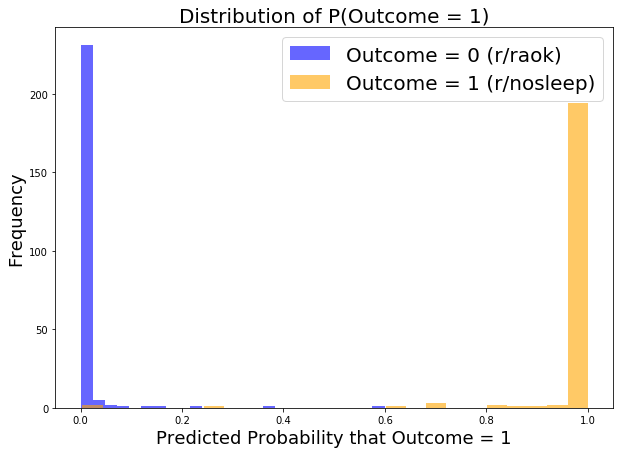

In [30]:
# Create figure.
plt.figure(figsize = (10,7))

# Creatinfg two histograms of observations, with blue (left) from r/raok and yellow (right) from r/nosleep
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0 (r/raok)')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1 (r/nosleep)')

# Labeling of axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=20)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Creating of legends
plt.legend(fontsize=20);

There is little to none in overlap between the classified subreddits, suggesting a model of good fit, and reinstating the strong accuracy observed.

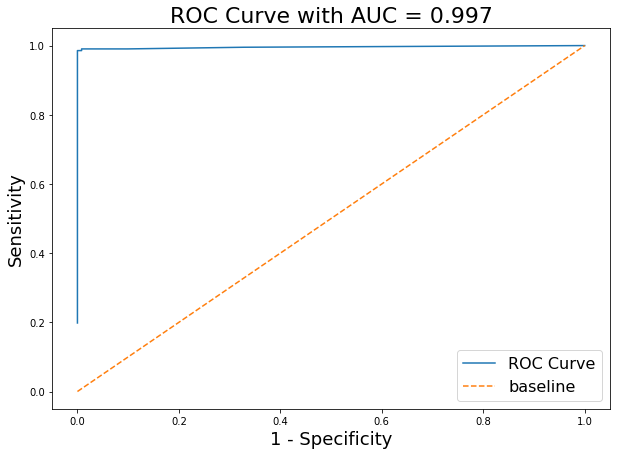

In [31]:
# Creating of figure
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

With an AUC score of 0.99, it suggests the r/nosleep and r/raok populations are perfectly separated, and the model is nearly as good as it can get.

### 7. Conclusion

Using the Logistic Regression (with Count Vectorizer) as a classification model, the 99% accuracy suggests that almost all of the posts are accurately classified into its respective subreddits.

The strength of the best performing model in classifying the posts into its subreddits is unsurprising, given that:
- Both posts engage in topics that have very little overlap, leading to distinct classification identifiers from both posts;
- r/nosleep is fictional, while r/randomactsofkindness is non-fiction, further distincting the language that is used in both subreddits.

While the model performed best for this two subreddits, it can be further stress-tested in situations where:
- A 3rd subreddit is introduced;
- Two subreddits with more topical overlap are used